<center>
<h1>Deduplicating document collections</h1>
</center>
-----------------------------------------------
## github.com/mattilyra/lsh

### Matti Lyra

### @mattilyra

This talk is about finding documents that are duplicates of each other, I hope to convince you that this is
- _not_ a trivial task
- _not_ necessarily a classification task
- definition of duplicate is application dependant
- possible to do with fairly simple tools

<center>
<h1>"What is the best book ever made?"</h1>
</center>

<center>
<br/>
<h2>"What is the most important book you have ever read?"</h2>
</center>

# Duplicate documents?

- stackoverflow.com (similar questions) (https://stackoverflow.blog/2009/04/29/handling-duplicate-questions/)
    - cut'n'paste duplicates (md5)
    - accidental duplicates

- Quora similar questions (https://www.kaggle.com/c/quora-question-pairs)
- Editorial Corrections in news
- Content Marketing
    - the same, or close to the same, content being pushed out to content federation networks
    - medium, slashdot, reddit

# Some Examples

## RCV1 (Reuters Corpus V1)





![](./gfx/RCV1-dup_01.png)

> "How can I be a good geologist?" ` == ` "What should I do to be a great geologist?"

> "What are the best ways to learn French?" ` == ` "How do I learn french genders?"

# Why is it a problem?

- skewed distribution
    - document level
    - token level
- inconsistent document labels
    - PyData Berlin 2018 reviews
    - wasted annotation effort
- increased algorithm training time

# Possible approaches

- treat deduplication as a classification task (Kaggle Quora)
- embed documents into a "semantic" vector space
    - word mover's distance
    - add / multiply word vectors together (plus Nearest Neighbours search)
    - ... or a bastardised version of "semantic" space (this talk)

Both of the above require comparisons between all pairs

In [17]:
# 100 ms per comparison, including vector lookups etc. etc.

(1000 ** 2 * 100) / 1000 / 60 / 60

27.77777777777778

In [18]:
# 100 ms per comparison, including vector lookups etc. etc.

(2000 ** 2 * 100) / 1000 / 60 / 60

111.11111111111111

In [20]:
# 100 ms per comparison, including vector lookups etc. etc.

(10000 ** 2 * 100) / 1000 / 60 / 60, (10000 ** 2 * 100) / 1000 / 60 / 60 / 24

(2777.777777777778, 115.74074074074075)

# Roofing and Paul Jaccard

![](./gfx/610px-Heinola_paanukatto.jpg)

## Shingles and Jaccard similarity
### partially overlapping bits of text


A worked example of shingling and Jaccard with examples to show that it isn't all that unreasonable as a method for document similarity.

In [31]:
def shingles(text, char_ngram=6):
    """Given a string, return partially overlapping character ngrams."""
    return set(text[head:head + char_ngram] for head in range(0, len(text) - char_ngram))

shingles('the cat sat on the mat')

{' cat s',
 ' on th',
 ' sat o',
 ' the m',
 'at on ',
 'at sat',
 'cat sa',
 'e cat ',
 'he cat',
 'n the ',
 'on the',
 'sat on',
 't on t',
 't sat ',
 'the ca',
 'the ma'}

## RCV1 (Jaccard = ~89%, ngram=6)





![](./gfx/RCV1-dup_01.png)

In [5]:
# duplicate = yes

q1 = "How can I be a good geologist?"
q2 = "What should I do to be a great geologist?"

def shingles(text, char_ngram=5):
    """Given a string, return partially overlapping character ngrams."""
    return set(text[head:head + char_ngram] for head in range(0, len(text) - char_ngram))

len(shingles(q1) & shingles(q2)) / len(shingles(q1) | shingles(q2))

0.17307692307692307

In [7]:
# duplicate = yes

q1 = "I was suddenly logged off Gmail. I can't remember my Gmail password and just realized the recovery email is no longer alive. What can I do?"
q2 = "I can't remember my Gmail password or my recovery email. How can I recover my e-mail?"

len(shingles(q1) & shingles(q2)) / len(shingles(q1) | shingles(q2))

0.29936305732484075

In [12]:
# duplicate = no

q1 = "What are the best ways to learn French?"
q2 = "How do I learn french genders?"

len(shingles(q1) & shingles(q2)) / len(shingles(q1) | shingles(q2))

0.07272727272727272

In [55]:
import pandas as pd

questions = pd.read_csv('/usr/local/scratch/data/quora/quora_duplicate_questions.tsv', sep='\t', converters={'question1': str, 'question2': str},
                        nrows=5000, index_col='id')

In [56]:
def jaccard(s1, s2):
    return len(s1 & s2) / (len(s1 | s2) + 1e-15)

In [57]:
def sim(row):
    return jaccard(shingles(row['question1']), shingles(row['question2']))

questions['jaccard'] = questions.apply(sim, axis=1)

In [60]:
questions.head(n=50).sort_values('jaccard', ascending=False)

,qid1,qid2,question1,question2,is_duplicate,jaccard
id,,,,,,
16,33,34,What does manipulation mean?,What does manipulation means?,1,0.956522
13,27,28,What was your first sexual experience like?,What was your first sexual experience?,1,0.864865
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,0.847458
14,29,30,What are the laws to change your status from a...,What are the laws to change your status from a...,0,0.816327
25,51,52,What are some tips on making it through the jo...,What are some tips on making it through the jo...,0,0.772727
41,83,84,When can I expect my Cognizant confirmation mail?,When can I expect Cognizant confirmation mail?,0,0.765957
34,69,70,What is the best travel website in spain?,What is the best travel website?,0,0.742857
44,89,90,What universities does Rexnord recruit new gra...,What universities does B&G Foods recruit new g...,0,0.729167
42,85,86,"Can I make 50,000 a month by day trading?","Can I make 30,000 a month by day trading?",0,0.707317


# All pairs comparisons !!!

 - locality sensitive hashing

- minhashing

In [71]:
jaccard(shingles('the cat sat on the mat'), shingles('the cat sat on the sofa'))

0.7368421052631579

In [68]:
shingles('the cat sat on the mat'), shingles('the cat sat on the sofa')

({' cat s',
  ' on th',
  ' sat o',
  ' the m',
  'at on ',
  'at sat',
  'cat sa',
  'e cat ',
  'he cat',
  'n the ',
  'on the',
  'sat on',
  't on t',
  't sat ',
  'the ca',
  'the ma'},
 {' cat s',
  ' on th',
  ' sat o',
  ' the s',
  'at on ',
  'at sat',
  'cat sa',
  'e cat ',
  'he cat',
  'he sof',
  'n the ',
  'on the',
  'sat on',
  't on t',
  't sat ',
  'the ca',
  'the so'})

In [75]:
shingle_ids = {}
shingle_ids_rev = {}
for s in shingles('the cat sat on the mat') | shingles('the cat sat on the sofa'):
    id_i = len(shingle_ids)
    shingle_ids[id_i] = s
    shingle_ids_rev[s] = id_i

In [76]:
d1 = shingles('the cat sat on the mat')
d2 = shingles('the cat sat on the sofa')

In [81]:
import ipywidgets as widgets

In [95]:
type(df)

pandas.core.frame.DataFrame

In [198]:
import bokeh

bokeh.io.output_notebook()

Loading BokehJS ...

In [365]:
import random

from bokeh.models import DataTable, TableColumn, Text
from bokeh.models import ColumnDataSource

get_shingle = lambda d, shingle: shingle if shingle in d else '' 

keys = list(shingle_ids.keys())
random.shuffle(keys)
perm = [(shingle_id, get_shingle(d1, shingle_ids[shingle_id]), get_shingle(d2, shingle_ids[shingle_id])) for shingle_id in keys]
df = pd.DataFrame.from_records(perm, columns=['shingle ID', 'doc 1', 'doc 2'])

source = ColumnDataSource(df.to_dict(orient='list'))

In [371]:
table = DataTable(columns=[TableColumn(field='shingle ID', title='Shingle ID'),
                           TableColumn(field='doc 1', title='Doc 1'),
                           TableColumn(field='doc 2', title='Doc 2')],
                  source=source)

In [396]:
row = bokeh.layouts.row([table])
t = bokeh.io.show(row, notebook_handle=True)

A random permutation of the rows can produce any of `19! == 121645100408832000` ([factorial](https://en.wikipedia.org/wiki/Factorial)) different orderings. However we only care about the orderings for which the two columns have the same lowest row number with a 1. Since the rows with zeros on them don't count, there are 19 rows with a one on it in any column, and 14 rows with a 1 in both columns. All a random permutation can therefore do is put two out of the five rows in the lowest row number, in other words produce a hash collision with a probability `14/19 ~ 0.736`.

In [539]:
sims = []

In [550]:
for _ in range(500):
    random.shuffle(keys)
    d1_min = min([i for i, shingle_id in enumerate(keys) if get_shingle(d1, shingle_ids[shingle_id])])
    d2_min = min([i for i, shingle_id in enumerate(keys) if get_shingle(d2, shingle_ids[shingle_id])])
    sims.append(d1_min == d2_min)
    source.patch({'shingle ID': [(i, shingle_id) for i, shingle_id in enumerate(keys)],
                  'doc 1': [(i, get_shingle(d1, shingle_ids[shingle_id])) for i, shingle_id in enumerate(keys)],
                  'doc 2': [(i, get_shingle(d2, shingle_ids[shingle_id])) for i, shingle_id in enumerate(keys)]})
    bokeh.io.push_notebook(handle=t)

In [551]:
len(sims)

610

In [552]:
sum(sims) / len(sims)

0.7278688524590164

The problem with these shingles is that they do not allow us to compute the similarities of large numbers of documents very easily, we have to do an all pairs comparison. To get around that we can use locality sensitive hashing, but before LSH we'll turn the documents into a more manageable and uniform representation: a fixed length fingerprint comprised of k minhashes.

Every document has a different number of shingles depending on the length of the document, for a corpus of any size predicting the memory requirements for an all pairs comparison is not possible as each document will consume a variable amount of memory. For LSH we would like to have a fixed length representation of the documents without changing the semantics of document similarity. This is where minhashing comes in. It turns out that the probability of a hash collision for a minhash is exactly the Jaccard similarity of two sets. This can be seen by considering the two sets of shingles as a matrix. For two dummy documents the shingles could be represented as the table below (the zeros and ones indicate if a shingle is present in the document or not). Notice that the Jaccard similarity of the documents is 2/5.

<table>
<th colspan=4><center>Document Shingles</center></th>
<tr> <td>row</td><td>shingle ID</td><td>Doc 1</td><td>Doc 2</td> </tr>
<tr> <td>1</td><td>1</td><td>0</td><td>1</td> </tr>
<tr> <td>2</td><td>2</td><td>1</td><td>1</td> </tr>
<tr> <td>3</td><td>3</td><td>0</td><td>1</td> </tr>
<tr> <td>4</td><td>4</td><td>1</td><td>0</td> </tr>
<tr> <td>5</td><td>5</td><td>1</td><td>1</td> </tr>
<tr> <td>6</td><td>6</td><td>0</td><td>0</td> </tr>
</table>

The `minhash` corresponds to a random permutation of the rows and gives back the row number where the first non zero entry is found. For the above table the minhash for documents one and two would thus be 2 and 1 respectively - meaning that the documents are not similar. The above table however is just one ordering of the shingles of each document. A different random permutation of the rows will give a different minhash, in this case 2 and 2, making the documents similar.

_(Mining Massive Datasets, Leskovec et. al http://www.mmds.org/ Retrieved April 15th)_

<table>
<th colspan=9><center>Document Shingles</center></th>
<tr> <td>row</td><td>shingle ID</td><td>Doc 1</td><td>Doc 2</td> <td>|</td> <td>row</td><td>shingle ID</td><td>Doc 1</td><td>Doc 2</td> </tr>
<tr> <td>1</td><td>1</td><td>0</td><td>1</td>                    <td>|</td> <td>1</td><td>6</td><td>0</td><td>0</td> </tr>
<tr> <td>2</td><td>2</td><td>1</td><td>1</td>                    <td>|</td> <td>2</td><td>2</td><td>1</td><td>1</td> </tr>
<tr> <td>3</td><td>3</td><td>0</td><td>1</td>                    <td>|</td> <td>3</td><td>3</td><td>0</td><td>1</td> </tr>
<tr> <td>4</td><td>4</td><td>1</td><td>0</td>                    <td>|</td> <td>4</td><td>1</td><td>0</td><td>1</td> </tr>
<tr> <td>5</td><td>5</td><td>1</td><td>1</td>                    <td>|</td> <td>5</td><td>4</td><td>1</td><td>0</td> </tr>
<tr> <td>6</td><td>6</td><td>0</td><td>0</td>                    <td>|</td> <td>6</td><td>5</td><td>1</td><td>1</td> </tr>
</table>

# Some examples of the library

![](gfx/lsh_github.png)

In [608]:
import lsh
from lsh.cache import Cache
from lsh.minhash import MinHasher

import itertools

# create a fingerprint of each document using
# - 100 minhashes
# - character ngrams of 5 characters
# - a hash space of 32 bits (this impacts the probability of hash collisions)
hasher = MinHasher(seeds=100, char_ngram=5, hashbytes=4)

def rcv1_headlines(n):
    with open('/usr/local/scratch/data/rcv1/headline.text.txt', 'r') as fh:
        feed = itertools.islice(fh, n)
        for line in feed:
            doc_id, doc = line.split('\t', 1)
            yield doc_id, doc
            
docs = list(rcv1_headlines(5000))

In [613]:
%timeit hasher.fingerprint(doc)

The slowest run took 8202.19 times longer than the fastest. This could mean that an intermediate result is being cached.
10000000 loops, best of 3: 184 ns per loop


In [612]:
%timeit cache.is_duplicate(doc)

10000 loops, best of 3: 157 µs per loop


In [616]:
%%timeit
# create the LSH cache
cache = Cache(num_bands=10, hasher=hasher)
for doc_id, doc in docs:
    if not cache.is_duplicate(doc):
        cache.add_doc(doc, doc_id=doc_id)
#     else:
#         duplicates = list(cache.get_duplicates_of(doc))
#         print(f'Document {doc_id} has {len(duplicates)} duplicates. {[doc_id] + duplicates}')

1 loop, best of 3: 1.1 s per loop


In [607]:
for doc_id, doc in rcv1_headlines(10000):
    if doc_id in ['2539', '2536', '2334']:
        print(doc)

Fed seen holding U.S. interest rates steady.  The U.S. Federal Reserve met on Tuesday to discuss the future course of interest rates and was widely expected to keep rates steady amid mixed signals on the economy. "The speeches made by various Fed governors and by bank presidents recently are not pointing toward tightening," said Preston Martin, chairman of HomeVest Financial Services Inc. in San Francisco. "I would think the odds are very heavily weighted toward the prospect that there will be no change at the next policy-making meeting," said Martin, a former Fed vice chairman. The central bank's policy-making Federal Open Market Committee (FOMC) started meeting at 9 a.m. EDT (1300 GMT). If past practice is followed, any decision should be announced around 2:15 p.m. EDT (1815 GMT). Martin's forecast was shared unanimously by the 30 economists polled last week by Reuters, although some of those experts did not rule out a rate rise later this year. Financial markets marked time Tuesday 

In [571]:
doc = !head -n 1 /usr/local/scratch/data/truly_native/gz/0fn8ztwu

In [577]:
from bs4 import BeautifulSoup as BS

In [586]:
doc = ' '.join(doc.fields()[0][2:])

In [593]:
with open('/home/matti/Desktop/test.html', 'wb') as fh:
    fh.write(doc.encode('utf8'))

In [588]:
htmldoc = BS(doc, "html5lib")

In [591]:
htmldoc.find('body')

'   Kale Frittata - A Healthy Breakfast Casserole Colorado Denver Foodblog German recipes My Kitchen in the Rockies | A Denver, Colorado Food Blog               .socialwrap li.icon_text a img, .socialwrap li.iconOnly a img, .followwrap li.icon_text a img, .followwrap li.iconOnly a img{border-width:0 !important;background-color:none;}#follow.left {width:56px;position:fixed; left:0; top:100px;padding:10px 0;font-family:impact,charcoal,arial, helvetica,sans-serif;-moz-border-radius-topright: 5px;-webkit-border-top-right-radius:5px;-moz-border-radius-bottomright:5px;-webkit-border-bottom-right-radius:5px;}#follow.left ul {padding:0; margin:0; list-style-type:none !important;font-size:24px;color:black;} #follow.left ul li {padding-bottom:12px;list-style-type:none !important;padding-left:4px;padding-right:4px} #follow img{border:none;}#follow.left ul li.followme {margin:0 4px;} #follow.left ul li.followme img {border-width:0;display:block;overflow:hidden; background:transparent url(http://ww

----

Applications utilising Natural Language Processing (NLP) have recently gained alot of traction partly due to advances in artificial neural networks. One especially tricky problem for NLP however begins before you even get to the "processing" part, namely the deduplication of the incoming document stream.

Online platforms such as recommender systems as well as comment forums and user feedback systems all face the problem of detecting which documents are duplicates of each other. As many NLP tasks tend to be computationally expensive it is desirable to only apply those processes to new documents. The class label or action taken upon seeing a duplicate document is likely the same as that for the original.

It is also important to keep duplicates out of your training data to prevent them from unfairly biasing the trained model. The prevalence of certain document features and their relation to the task at hand can be severly biased by multiple duplicate entried of the same document or documents.

How do you determine if a document is a duplicate or more importantly a _near_ duplicate? Ideally the method of deduplication would work online and have predictable resource requirements. As always the faster the model works the better, especially at decoding time, that is when the model is being applied to new unseen instances.

I will first outline a simple and effective way of detecting near duplicates: character shingles and Jaccard similarity. I'll then discuss ways of making that process computationally feasible using locality sensitive hashing with minhash. Before we get to the nitty gritty of detecting near duplicates let's first consider where duplicate documents come from and what it means for an article to be a near duplicate.

# Document Similarity and Duplicates

When we talk about similar documents we usually mean documents that are semantically related, for instance two different news articles about the same event. There are a number of ways for determining the semantic relatedness of documents, for instance Latent Dirichlet Allocation (LDA) or neural language models. The semantic relatedness however is not what I mean by near duplicate documents. Near duplicates are not two different takes on one event but explicitly the same article duplicated across different channels. Near duplicate documents are of course also semantically related but it is important to make the distinction. 

Semantic similarity of documents is relatively easy for humans to detect but extremely difficult to do algorithmically, especially for longer documents. The main area of research here is distributional semantics, specifically distributional composition. In short distributional composition is about how the semantics of individual words should be composed together to form a semantic represenatation of larger pieces of text like sentences and documents, neural language models are one example of this.

Distributional composition is an active area of research and I won't focus on it here, if you're interested you'll probably want to look at the publications coming out of [ACL](http://www.aclweb.org/anthology/P/P16/), [TACL](https://www.transacl.org/ojs/index.php/tacl), [EMLNP](http://www.aclweb.org/anthology/D/D16/) and [NIPS](https://nips.cc/Conferences/2016). The second and much simpler kind of similarity is character based similarity, which quite simply measures the character overlap between two sentences or documents. It is good practice for any budding data scientist to start with the simplest possible method to establish a baseline before moving to more complex methods, therefore I'll focus on character based similarity and see how far that gets us.

# Where Do Duplicates Come From?

Duplicates are often produced in news media when a content producer like Reuters or the Associated Press distributes an article to a number publishers. Each publisher will typically add a paragraph or a footer making each copy slightly different from each other. A web crawler that monitors the sites of the individual publishers will see many near duplicate articles as each copy was essentially written by Reuters and only slightly modified by the other publishers. 

Duplicate news articles also tend to come in the form of updated news stories. Typically publishers will use an older version of the article and add a paragraph or two in the beginning with the new updated information, the rest of the article typically remains unchanged.

Near duplicates can also appear in user feedback systems in the event of a system or process failure. The feedback system will suddenly log a number of a documents created by different users that all look roughly similar. Product or service review sites can also experience this, possibly in the form of spam reviews being posted by automated systems.

Another interesting data set that potentially contains duplicates is the recently released [Quora Question Pairs](https://data.quora.com/First-Quora-Dataset-Release-Question-Pairs) dataset. Here the aim is specifically to find questions that are semantically the same, but often those questions are just slighty paraphrased ones. 

## Paul Jaccard and Roofing

Now that we know where near duplicated come from and how they differ from documents that are semantically related, let's outline how one could go about detecting them.

The method relies on two simple concepts, character shingles and the Jaccard similarity. 'Shingle' is a term that comes from roofing and refers to partially overlapping pieces of clay, stone, wood, asphalt or some such bits of roofing material.

![](../assets/610px-Heinola_paanukatto.jpg)

The idea for character shingles is similar, create a document representation of consecutive overlapping character n-grams from each document. "Cat sat on the mat", when 4-shingled becomes (`'The '`, `'he c'`, `'e ca'`, `' cat'`, ... ,`'at.'`). Notice that punctuation and whitespace are all part of the process. This represenatation preserves word order, to some extent, and allows comparing documents based on the sets of character shingles. The similarity of those documents can then simply be defined as the Jaccard similarity of the two sets of shingles; the number of elements (shingles) they have in common as a proportion of the combined size of the two sets, or the size of the intersection divided by the size of the union. 

For two dummy sentences let's see how the length of the character shingle effects the similarity of the documents. We'll use `python`'s `matplotlib` and `seaborn` libraries to plot the similarities.

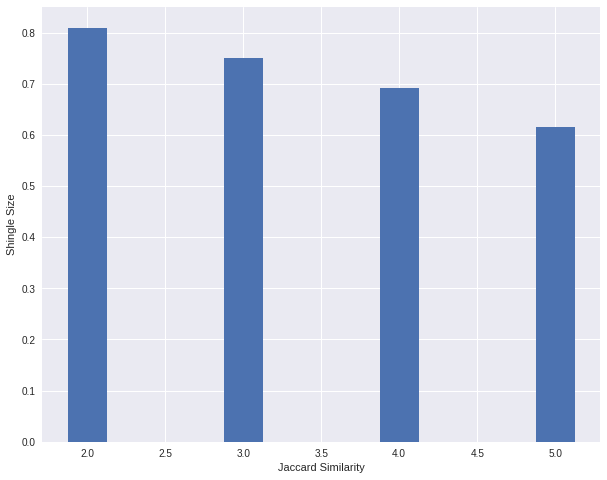

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

s1 = "The cat sat on the mat."
s2 = "The red cat sat on the mat."

similarities = []
for shingle_size in range(2, 6):
    shingles1 = set([s1[max(0, i - shingle_size):i] for i in range(shingle_size, len(s1) + 1)])
    shingles2 = set([s2[max(0, i - shingle_size):i] for i in range(shingle_size, len(s2) + 1)])
    jaccard = len(shingles1 & shingles2) / len(shingles1 | shingles2)
    similarities.append(jaccard)

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
_ = plt.bar([2,3,4,5], similarities, width=0.25)
_ = plt.xlabel('Jaccard Similarity')
_ = plt.ylabel('Shingle Size')

Leaving aside the discussion of whether a red cat sitting on a mat is in fact a "duplicate" of a cat sitting on a mat, [what it means for something to be red](https://en.wikipedia.org/wiki/Qualia) or indeed a cat, I will declare those two "documents" as duplicates of each other. With a shingle size of 2 we get a similarity of `~0.81` (or 81%) and with a shingle size of 5 we get a similarity of `~0.62` or 62%.  

The size of the shingle clearly has an impact on the effectiveness of this approach, one should however bear in mind that the two "documents" are very short especially in comparison to a shingle size of 5. The average word length in those two documents is just under 3, so a shingle size of 5 is actually comparing chunks that are bigger than single words. For longer documents that better reflect actual language usage the shingling will produce much more reasonable outputs. There are of course cases where this kind of character similarity will fail, let's explore those corner cases in a bit more detail.

## Where Character Similarity Fails

It is not difficult to come up with sentences that are semantically the same but share only a small proportion of their shingles, for example: "What's the flight time from Berlin to Helsinki" and "How long does it take to fly from Berlin to Helsinki" are semantically exactly the same but have very few words or character n-grams in common. On the other hand "What's the flight time from Berlin to Helsinki" and "What's the flight time from Berlin to Oulu" are semantically not the same but have a large character overlap.

In [10]:
s1 = "what's the flight time from Berlin to Helsinki?"
s2 = "how long does it take to fly from Berlin to Helsinki?"

shingles1 = set([s1[max(0, i-4):i] for i in range(4, len(s1) + 1)])
shingles2 = set([s2[max(0, i-4):i] for i in range(4, len(s2) + 1)])

len(shingles1 & shingles2) / len(shingles1 | shingles2)

0.30985915492957744

In [11]:
s1 = "what's the flight time from Berlin to Helsinki?"
s2 = "what's the flight time from Berlin to Oulu?"

shingles1 = set([s1[max(0, i-4):i] for i in range(4, len(s1) + 1)])
shingles2 = set([s2[max(0, i-4):i] for i in range(4, len(s2) + 1)])

len(shingles1 & shingles2) / len(shingles1 | shingles2)

0.7142857142857143

These two are again simple example sentences but it is important to understand where the limits of any particular method or technology lie. The initial exploration has already revealed a critical relationship between the length of the document and the length of the character shingle, suggesting that the method might not work so well for data that contains a lot of short one sentence documents, for instance tweets. Equally it's unlikely to work all that well for rephrased sentences or documents, the semantics of rephrased or summarised information should not change but the character representation will.

This should all be fine however, as we've already defined the task to be about finding near duplicate documents not semantically similar ones, for document collections with longer documents this method should work very well.

# A Real World Example 

## Deduplicating the Reuters RCV1 corpus [1]

The Reuters Corpus, Volume 1 (RCV1) corpus is a commonly used resource for various NLP tasks, especially document classification. It was made available in 2000 by Reuters Ltd. and consists of ~800,000 english language news stories collected between August 20th 1996 and August 19th 1997 from the Reuters news wire.

I've preprocessed the corpus so that it is all in a single file, one line per document. Each line has the format:

    ITEMID<TAB>HEADLINE<SPACE>TEXT

In [31]:
!wc -l /usr/local/scratch/data/rcv1/headline.text.txt

806791 /usr/local/scratch/data/rcv1/headline.text.txt


In [32]:
!head -1 /usr/local/scratch/data/rcv1/headline.text.txt

2286	Recovery excitement brings Mexican markets to life.  Emerging evidence that Mexico's economy was back on the recovery track sent Mexican markets into a buzz of excitement Tuesday, with stocks closing at record highs and interest rates at 19-month lows. "Mexico has been trying to stage a recovery since the beginning of this year and it's always been getting ahead of itself in terms of fundamentals," said Matthew Hickman of Lehman Brothers in New York. "Now we're at the point where the fundamentals are with us. The history is now falling out of view." That history is one etched into the minds of all investors in Mexico: an economy in crisis since December 1994, a free-falling peso and stubbornly high interest rates. This week, however, second-quarter gross domestic product was reported up 7.2 percent, much stronger than most analysts had expected. Interest rates on governent Treasury bills, or Cetes, in the secondary market fell on Tuesday to 23.90 percent, their lowest level since 

Some duplicate items are present in the corpus so let's see what happens when we apply LSH to it. First a helper function that takes a file pointer and some parameters for `minhash` and LSH and then finds duplicates.

In [3]:
import itertools

# from lsh import lsh, minhash # https://github.com/mattilyra/lsh

# a pure python shingling function that will be used in comparing
# LSH to true Jaccard similarities
def get_shingles(text, char_ngram=5):
    return set(text[head:head + char_ngram] for head in range(0, len(text) - char_ngram))


def jaccard(set_a, set_b):
    intersection = set_a & set_b
    union = set_a | set_b
    return len(intersection) / len(union)

Let's first try this pure `python` implementation on the first 500 documents.

In [4]:
shingles = []
with open('/usr/local/scratch/data/rcv1/headline.text.txt', 'r') as fh:
    for i_line, line in enumerate(fh):
        if i_line > 500:
            break
        document_id, article_text = line.split('\t', maxsplit=1)
        shingles.append(get_shingles(article_text.lower()))

In [5]:
duplicates = []
for i_doc in range(len(shingles)):
    for j_doc in range(i_doc + 1, len(shingles)):
        jaccard_similarity = jaccard(shingles[i_doc], shingles[j_doc])
        is_duplicate = jaccard_similarity >= 0.75
        if is_duplicate:
            duplicates.append((i_doc, j_doc, jaccard_similarity))

In [32]:
import pandas as pd
from IPython.display import display

with pd.option_context('display.precision', 2):
    display(pd.DataFrame(duplicates, columns=['Document ID', 'Document ID', 'Jaccard Similarity']).head(n=10))

,Document ID,Document ID,Jaccard Similarity
0,2,3,1.00
1,13,160,1.00
2,19,180,0.88
3,22,176,0.91
4,25,77,0.80
5,29,69,0.75
6,31,32,1.00
7,47,190,1.00
8,48,49,1.00
9,48,195,0.84


If we look at the documents themselves we can easily see how accurately the algorithm is detecting duplicate documents. Let's see what documents `2` and `3` look like. We don't really care what the first 6 character are as those are just the `document ID` and a `<TAB>`.

In [26]:
!head -4 /usr/local/scratch/data/rcv1/headline.text.txt | tail -2 | cut -c 6-350

CompuServe reports loss, cutting work force.  CompuServe Corp. Tuesday reported a surprisingly large $29.6 million fiscal first-quarter loss, blaming a decline in the number of subscribers to the No. 2 online service and spending on a new family-oriented service and improvements. CompuServe predicted a second-quarter loss but said earnings wou
CompuServe reports loss, cutting work force.  CompuServe Corp. Tuesday reported a surprisingly large $29.6 million fiscal first-quarter loss, blaming a decline in the number of subscribers to the No. 2 online service and spending on a new family-oriented service and improvements. CompuServe predicted a second-quarter loss but said earnings wou


Judging by the first 350 characters of the articles it would seem that the documents are indeed exact duplicates. Let's see what near duplicates look like, this time we'll take documents `25` and `77` which have been assigned a similarity score of `0.80` or `80%`.

In [27]:
!head -26 /usr/local/scratch/data/rcv1/headline.text.txt | tail -1 | cut -c 6-450

Lloyd's chief undergoes U.S. grilling.  Lloyd's of London chief executive Ron Sandler on Tuesday faced a three-hour grilling in a crucial United States court case, which threatens at the last minute to upset a recovery plan for the 300-year-old insurance market. Tens of thousands of investors in Lloyd's worldwide are anxiously awaiting the outcome of the case in Virginia, where U.S. investors (Names) have applied for an injunction to stop th


In [28]:
!head -78 /usr/local/scratch/data/rcv1/headline.text.txt | tail -1 | cut -c 6-450

Lloyd's braced for crucial U.S. court case ruling.  Lloyd's of London was braced on Tuesday for a possible ruling in a crucial United States court case, which threatens at the last minute to upset a recovery plan for the 300-year-old insurance market. Tens of thousands of investors in Lloyd's worldwide are anxiously awaiting the outcome of the case in Virginia, where U.S. investors (Names) have applied for an injunction to stop the recovery 


There are more differences between the two, but they are essentially talking about the exact same thing. A few sentences have been paraphrased but otherwise the documents look identical. So the method seems to be working.

In [29]:
len(duplicates), (len(duplicates) / 500) * 100

(36, 7.199999999999999)

Approximately 7 percent of the first 500 documents are in fact duplicates, that translates to about 56,000 duplicate documents in the relatively small 800,000 document dataset overall. The problem is that finding those duplicates took quite a long time as computing the Jaccard similarity of the documents requires comparing every document to every other document, this approach is clearly not scalable. This is where Locality Sensitive Hashing with `minhash` comes in.

# Locality Sensitive Hashing

Locality Sensitive Hashing (LSH) is a generic hashing technique that aims, as the name suggests, to preserve the local relations of the data while significantly reducing the dimensionality of the dataset. It can be used for computing the Jaccard similarities of elements as well as computing the cosine similarity depending on exactly which hashing function is selected, more on this later.

LSH is a slightly strange hashing technique as it tries to _ensure_ hash collisions for similar items, something that hashing algorithms usually try to avoid. The overall aim is to reduce the number of comparisons needed to find similar items, the hash collisions come in handy here as similar documents have a high probability of having the same hash value. The hash values can be treated as an address for a bucket that contains likely duplicates, this reduces the number of comparisons needed as only the documents contained in a bucket, not every other document, need to be looked at to find the real duplicates.

Locality sensitive hashing is great but it's not quite enough on its own. It would also be great if we could predict the computational requirements of the process overall. As it stands each document is shingled into some number of shingles, the exact number of which depends on the length of the document and the size of the shingle. Each document therefore has an unpredictable memory footprint, ideally we'd have a document representation whose size is independent of the length of the document without changing the semantics of document similarity.

This is where `minhash` comes in, it's a specific hash function that has some desirable properties for this use case. Namely, it turns out that the probability of a hash collision for a `minhash` is exactly the Jaccard similarity of two sets. This can be seen by considering the two sets of shingles as a matrix. For two dummy documents the shingles could be represented as the table below (the zeros and ones indicate if a shingle is present in the document or not). For this discussion it doesn't matter what the actual shingles are, but notice that the Jaccard similarity of the documents is `2/5`, that is `2` out of `5` shingles (shingle IDs 2 and 4) are shared between the documents.


<table width="300px">
<thead>
<tr>
<th colspan="4" class="center">Document Shingles</th>
</tr>
<tr> <th>row</th><th>shingle ID</th><th>Doc 1</th><th>Doc 2</th> </tr>
</thead>
<tbody class="center">
<tr> <td>1</td><td>1</td><td>0</td><td>1</td> </tr>
<tr> <td>2</td><td>2</td><td>1</td><td>1</td> </tr>
<tr> <td>3</td><td>3</td><td>0</td><td>1</td> </tr>
<tr> <td>4</td><td>4</td><td>1</td><td>1</td> </tr>
<tr> <td>5</td><td>5</td><td>1</td><td>0</td> </tr>
<tr> <td>6</td><td>6</td><td>0</td><td>0</td> </tr>
</tbody>
</table>


The `minhash` corresponds to a random permutation of the rows and gives back the row number where the first non zero entry is found. For the above table the `minhash` for documents one and two would thus be `2` and `1` respectively - meaning that the documents are not similar. The above table however is just one ordering of the shingles of each document. A different random permutation of the rows will give a different `minhash`, in this case `2` and `2`, making the documents similar.

<table width="300px">
<thead>
<tr>
<th colspan="4" class="center">Document Shingles</th>
</tr>
<tr> <th>row</th><th>shingle ID</th><th>Doc 1</th><th>Doc 2</th> </tr>
</thead>
<tbody class="center">
<tr> <td>1</td><td>6</td><td>0</td><td>0</td> </tr>
<tr> <td>2</td><td>2</td><td>1</td><td>1</td> </tr>
<tr> <td>3</td><td>3</td><td>0</td><td>1</td> </tr>
<tr> <td>4</td><td>1</td><td>0</td><td>1</td> </tr>
<tr> <td>5</td><td>4</td><td>1</td><td>1</td> </tr>
<tr> <td>6</td><td>5</td><td>1</td><td>0</td> </tr>
</tbody>
</table>

A random permutation of the rows can produce any of `6! == 720` ([factorial](https://en.wikipedia.org/wiki/Factorial)) different orderings. However we only care about the orderings for which the two columns have the same lowest row number with a 1, that is `shingle ID` $$\in \{2, 4\}$$. Since the rows with zeros on them don't count, there are 5 rows with a one on it in any column, and two rows with a 1 in both columns. All a random permutation can therefore do is put two out of the five rows in the lowest row number, in other words produce a hash collision with a probability `2/5`.

The above explanation follows Chapter 3 of [Mining Massive Datasets](http://www.mmds.org) (Leskovec, Rajaraman and Ullman). An in depth explanation for why and how `minhash` works is provided there along with other interesting hash functions.

Using `minhash` we can create a fixed length _fingerprint_ from each document, where each item in the fingerprint is a different random permutation of the rows. The longer the fingerprint the higher the likelihood that duplicate documents have a hash collision for at least one of the permutations. You're not guaranteed to get a collision, but you get to control the memory requirements of your document deduplication algorithm. The graph below shows the relation between the actual Jaccard similarity of a pair of documents and the probability it will be discovered for a few different parameter settings of LSH.

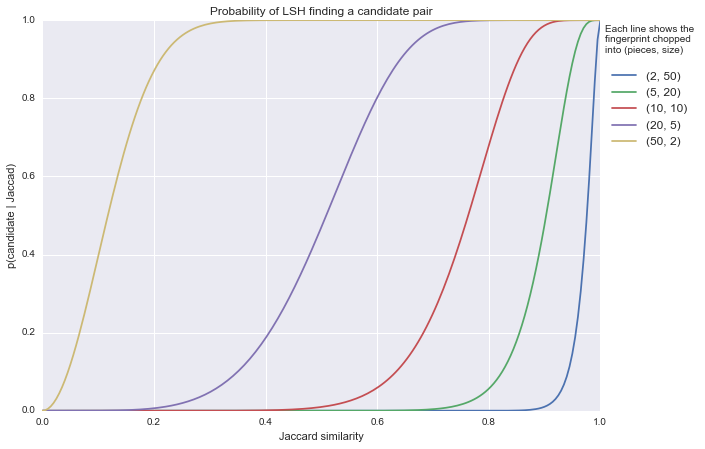

In [4]:
df = pd.DataFrame(data=[(2, 50), (50, 2), (10, 10), (5, 20), (20, 5)], columns=['pieces', 'size'])
df['hashes'] = df['pieces'] * df['size']
for pr in np.linspace(0, 1, 200):
    df[pr] = 1 - (1 - pr**df['size']) ** df['pieces']

df = pd.pivot_table(df, index=['hashes', 'pieces', 'size'])

ax = df.T.plot(figsize=(10, 7), title='Probability of LSH finding a candidate pair');
plt.ylabel('p(candidate | Jaccad)');
plt.xlabel('Jaccard similarity');
plt.legend(list(df.loc[ix[100]].index),
           bbox_to_anchor=(1., 1, 1., 0), loc='upper left', fontsize=12, 
           ncol=1, borderaxespad=0., title='Each line shows the\nfingerprint chopped\ninto (pieces, size)\n');

The naive pure `python` implementation is quite slow and not really usable in production. I've made a much more robust implementation that utilizes `cython` and `murmurhash` for very fast and memory efficient creation of the document fingerprints, the implementation is freely available on github at [https://github.com/mattilyra/LSH](https://github.com/mattilyra/LSH).

Here is what the document deduplication routine would look like using the `LSH` library with default settings.

In [ ]:
import lsh
from lsh import minhash

# create a fingerprint of each document using
# - 100 minhashes
# - character ngrams of 5 characters
# - a hash space of 32 bits (this impacts the probability of hash collisions)
hasher = minhash.MinHasher(seeds=100, char_ngram=5, hashbytes=4)

# create the LSH cache
cache = lsh.Cache(bands=10, hasher=hasher)
with open('/usr/local/scratch/data/rcv1/headline.text.txt', 'rb') as fh:
    feed = itertools.islice(fh, 100)
    for line in feed:
        doc_id, doc = line.split('\t', 1)
        if not cache.is_duplicate(line):
            cache.add_doc(line)
        else:
            duplicates = cache.get_duplicates_of(doc)
            print(f'Document {doc_id} has {len(duplicates)} duplicates.')